# fbprophet

Prophet is a method for forecasting time series based on an additive model. Non linear trends are fit with daily, weekly and yearly seasonality along with the accounting for holidays.

This model is suited for datasets with strong seasonality components over a long period of time.

Custom seasonality and holiday effects can also be added to the models hyperparamteres, for more information on this follow the [link](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Load in the required libraries and python modules

In [1]:
\l ml/ml.q
\l ml/init.q
\l ../utils.q
proph:.p.import[`fbprophet]`:Prophet

No shared object files for cutils.q, only q implementations available


Importing plotly failed. Interactive plots will not work.


## Daily min temp

### Data Preparation

The below dataset contains the mimimum daily temperatures reached in Melbourne during the period from January 1981 - Decemeber 1990.


In [2]:
// Load in data and transform columns to appropriate format
show mintemp:("DF";enlist",")0:`:../data/dailytemp.csv

Date       Daily minimum temperatures in Melbourne, Australia, 1981-1990
------------------------------------------------------------------------
1981.01.01 20.7                                                         
1981.01.02 17.9                                                         
1981.01.03 18.8                                                         
1981.01.04 14.6                                                         
1981.01.05 15.8                                                         
1981.01.06 15.8                                                         
1981.01.07 15.8                                                         
1981.01.08 17.4                                                         
1981.01.09 21.8                                                         
1981.01.10 20                                                           
1981.01.11 16.2                                                         
1981.01.12 13.3                                    

When passing the data to the fbprophet module, it requires the following two columns to be present

 - ds = datetime values
 - y  = target values
 
fbProphet is also equipted with dealing with timeseries gaps in the dataset so there is no need to fill in any missing values

Any null values are deleted from the dataset.

In [3]:
// Transform data to appropriate format
mintemp:`ds`y xcol mintemp

// Delete nulls from the dataset
mintemp:delete from mintemp where ds=0N

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In [4]:
// Find the timestamp which splits the data 80/20
tts:ttstm[0.2;mintemp]

traintemp:tts`train
testtemp:tts`test

-1!"There is ",string[count traintemp]," datapoints in the training set"
-1!"There is ",string[count testtemp]," datapoints in the testing set"

"There is 2920 datapoints in the training set"


"There is 730 datapoints in the testing set"


### Fitting the model

The model is initialised with the weekly seasonality removed from the model as this is not a trend that effects temperature readings

The training set must be converted to a pandas dataframe

In [5]:
// Initialise the model
modeltemp:proph[`weekly_seasonality pykw 0b];

// Fit the model
\ts modeltemp[`:fit][.ml.tab2df[traintemp]];

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -126.949
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5125.28   0.000523827       79.5131      0.6371      0.6371      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       5125.45   0.000695317        71.698   7.349e-06       0.001      194  LS failed, Hessian reset 
     199       5125.57    0.00047311       65.3993       0.972       0.972      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5125.88   5.70008e-06       84.0219           1           1      422   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       5125.89   2.74912e-07       67.7324      0.7609      0.7609      482   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


1944 4196000


### Making forecasts

In order to make predictions, the future datetimes to be predicted must be passed to the model, using the `predict` attribute. This returns a table with each row representing the associated datetime prediction. In this forecast, the datetimes that were used in training the model are also returned

From this table, we are concerned with the following values


Column                        | Explanation
------------------------------|------------------------
ds                            | datetimes 
trend                         | Predicts the trend of the model on that datetime
yhat_lower                    | Lower confidence interval of predicted value
yhat_upper                    | Upper confidence interval of predicted value
yhat                          | The predictive value

In [6]:
// The results are forecasted for the testing time frame
\ts forecasttemp:.ml.df2tab modeltemp[`:predict][.ml.tab2df delete y from mintemp];

select ds,trend,yhat_lower,yhat_upper,yhat from forecasttemp

28481 651952


ds                            trend    yhat_lower yhat_upper yhat    
---------------------------------------------------------------------
1981.01.01D00:00:00.000000000 11.9252  11.98593   18.79076   15.47297
1981.01.02D00:00:00.000000000 11.92325 12.11097   18.97873   15.53656
1981.01.03D00:00:00.000000000 11.9213  12.12157   19.18336   15.59642
1981.01.04D00:00:00.000000000 11.91935 11.98825   19.29146   15.65175
1981.01.05D00:00:00.000000000 11.9174  12.23702   19.1235    15.7018 
1981.01.06D00:00:00.000000000 11.91545 12.17817   19.62977   15.74594
1981.01.07D00:00:00.000000000 11.9135  12.15482   19.03833   15.78367
1981.01.08D00:00:00.000000000 11.91155 12.16695   19.61386   15.81462
1981.01.09D00:00:00.000000000 11.9096  12.52089   19.186     15.83859
1981.01.10D00:00:00.000000000 11.90765 12.49406   19.49062   15.85552
1981.01.11D00:00:00.000000000 11.9057  12.30687   19.37757   15.86555
1981.01.12D00:00:00.000000000 11.90375 12.26383   19.4045    15.86895
1981.01.13D00:00:00.

In order ot calculate the mean squared error (mse) between the real and predicted values, the value `yhat` is extracted from the forecast table.

In [7]:
//Extract the appropriate dates from the forecasts
predstemp:exec yhat from forecasttemp where ds in "p"$testtemp[`ds]

// Calculate the error
-1!"The mean squared error is ",string .ml.mse[predstemp;testtemp`y]

"The mean squared error is 8.493681"


### Plotting the results

The predictions and trends forecasted by the model can also be plotted.

 - Black dots : indicate the data points used to train the model.
 - Dark blue  : plots the prediction
 - Light blue : plots the uncertainty interval

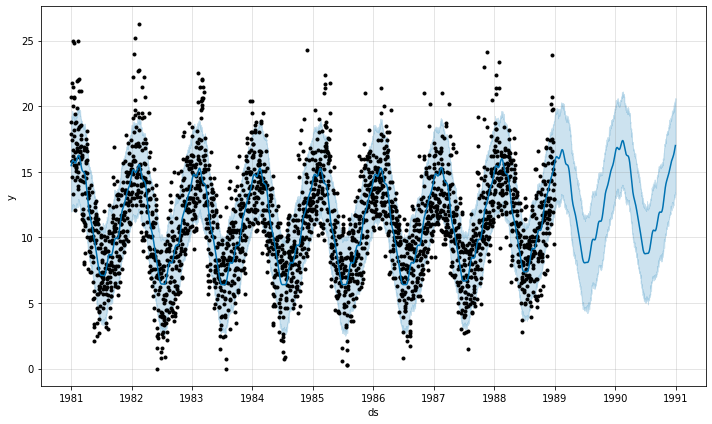

In [8]:
modeltemp[`:plot][.ml.tab2df forecasttemp];
p)import matplotlib.pyplot as plt
p)plt.show()

A common trend can be seen over the years above with a cyclical pattern being evident

The  components of the predicted model can also be plotted:

 - trend  : plots the trend (along with predicted trend) by date. The light blue line signifies the uncertainty interval in the prediction
 - weekly : plots the weekly seasonality/trends
 - plots  : plots the daily seasonality/trends

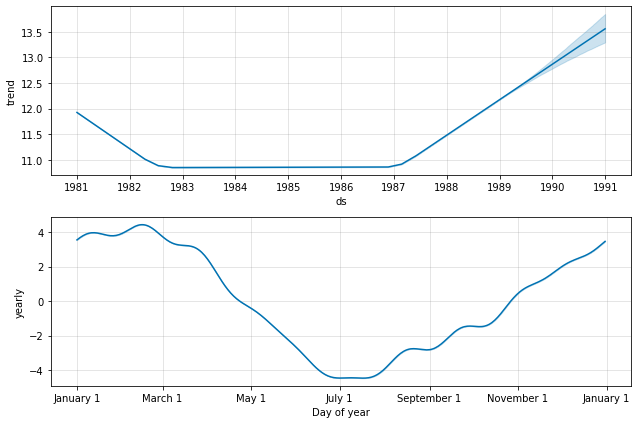

In [9]:
modeltemp[`:plot_components][.ml.tab2df forecasttemp];
p)plt.show()

Above, a clear monthly trend can be seen where the lowest temperature can be seen in July, with highest temperatures being obserbed from January to March

## Bike Rental

**In this section a more complex model is used with exogenous variables included in the training of the models**

### Data Preparation

The dataset is a provided by TFL to predict future bike sales per hour. Additional data is also given in the form of seasonality and climate information such as season, indication of whether it is a holiday, temperature, wind_speed, current weather etc .

For the purpose of these notebook, when predictions are being made, it is assumed that these climate information will be available based off future weather predictions. 

In [10]:
show bikes:("PFFFFFFBFF";enlist ",")0:`:../data/london_merged.csv

timestamp                     cnt  t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The datetimes and target columns in the dataframe are transformed to the fbprophet appropriate format.


fbprophet is also equipted with dealing with timeseries gaps in the dataset so there is no need to fill in any missing datetime values

In [11]:
show bikes:`ds`y xcol bikes

ds                            y    t1  t2   hum  wind_speed weather_code is_h..
-----------------------------------------------------------------------------..
2015.01.04D00:00:00.000000000 182  3   2    93   6          3            0   ..
2015.01.04D01:00:00.000000000 138  3   2.5  93   5          1            0   ..
2015.01.04D02:00:00.000000000 134  2.5 2.5  96.5 0          1            0   ..
2015.01.04D03:00:00.000000000 72   2   2    100  0          1            0   ..
2015.01.04D04:00:00.000000000 47   2   0    93   6.5        1            0   ..
2015.01.04D05:00:00.000000000 46   2   2    93   4          1            0   ..
2015.01.04D06:00:00.000000000 51   1   -1   100  7          4            0   ..
2015.01.04D07:00:00.000000000 75   1   -1   100  7          4            0   ..
2015.01.04D08:00:00.000000000 131  1.5 -1   96.5 8          4            0   ..
2015.01.04D09:00:00.000000000 301  2   -0.5 100  9          3            0   ..
2015.01.04D10:00:00.000000000 528  3   -

The data is then split into  a training and testing set (Making sure that no time leakage occurs). 

80% is chosen as train, 20% is testing data.

In [12]:
// Find the timestamp which splits the data 80/20
tts:ttstm[0.2;bikes]

trainbk:tts`train
testbk:tts`test

-1!"There is ",string[count trainbk]," datapoints in the training set"
-1!"There is ",string[count testbk]," datapoints in the testing set"

"There is 13931 datapoints in the training set"


"There is 3483 datapoints in the testing set"


### Training the model

The model is initialised, with the additional columns in the dataframe added as a regressor to the model to improve predictions.

Using the models `add_country_holidays` method, built in country specific holidays can be added to the model. This allows the model to take into account any holidays that may occur over the daterange in order to fit trends.

The test data, including these additional columns, are then passed to the model in the form of a pandas dataframe

In [13]:
// Initialise the model
modelbk:proph[];

// Add additional dataframe columns as regressors
{modelbk[`:add_regressor][x]}each `t1`t2`hum`wind_speed`weather_code`is_holiday`is_weekend`season;

// Add the built in UK holidays to the model
modelbk[`:add_country_holidays][`country_name pykw `UK];

// Fit the model on the training set
\ts modelbk[`:fit][.ml.tab2df[trainbk]];

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -248.217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       27766.8    0.00158505       547.842           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         27770   0.000422034       130.503       0.543       0.543      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       27771.2   0.000471529       95.3364           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       27771.4   6.35232e-05        177.85   3.199e-07       0.001      414  LS failed, Hessian reset 
     399       27771.6   6.74132e-05       91.4871      0.6142      0.6142      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426       27771.9   4.36434e-05    

33345 4196000


### Making forecasts

Predictions are now made on future datatimes by passing in the testing data including the datatimes and associated exogenous columns, excluding the target `y` values

In [14]:
// Forecast future values be excluding target values
\ts forecastbk:.ml.df2tab modelbk[`:predict][.ml.tab2df delete y from bikes];

select ds,trend,yhat_lower,yhat_upper,yhat from forecastbk

41937 26235600


ds                            trend    yhat_lower yhat_upper yhat     
----------------------------------------------------------------------
2015.01.04D00:00:00.000000000 1168.137 -1070.889  577.9709   -201.7717
2015.01.04D01:00:00.000000000 1168.14  -992.9136  682.4155   -146.1105
2015.01.04D02:00:00.000000000 1168.143 -1272.021  378.0712   -405.7262
2015.01.04D03:00:00.000000000 1168.146 -1644.415  45.62365   -763.1055
2015.01.04D04:00:00.000000000 1168.149 -1498.582  156.9526   -708.7197
2015.01.04D05:00:00.000000000 1168.152 -1132.383  520.5342   -349.2953
2015.01.04D06:00:00.000000000 1168.155 -653.3723  1037.651   169.0567 
2015.01.04D07:00:00.000000000 1168.157 28.09743   1681.499   811.0794 
2015.01.04D08:00:00.000000000 1168.16  344.8301   1984.103   1155.133 
2015.01.04D09:00:00.000000000 1168.163 98.12791   1802.924   977.1113 
2015.01.04D10:00:00.000000000 1168.166 -153.7767  1493.056   715.2661 
2015.01.04D11:00:00.000000000 1168.169 -592.9326  1054.385   221.0431 
2015.0

The only value that we are concerned with is the prediction value `yhat` in order ot calculate the mean squared error (mse) between the real and predicted values.

The testing data contains timestamps gaps, we are only extracting yhat values which corresponds to datetimes within the testing data in order to calculate the root mean squared log error

In [15]:
// Extract only the datetimes coinciding with the testing data
predsbk:exec yhat from forecastbk where ds in "p"$testbk[`ds]

// Calculate the error
-1!"The Mean Squared Log Error is ",string .ml.rmsle[predsbk;testbk`y]

"The Mean Squared Log Error is 0.8717692"


### Plotting Trends

The daily, weekly yearly and holidat trends are plotted below along with the forecasted values and associated uncertainty intervals.

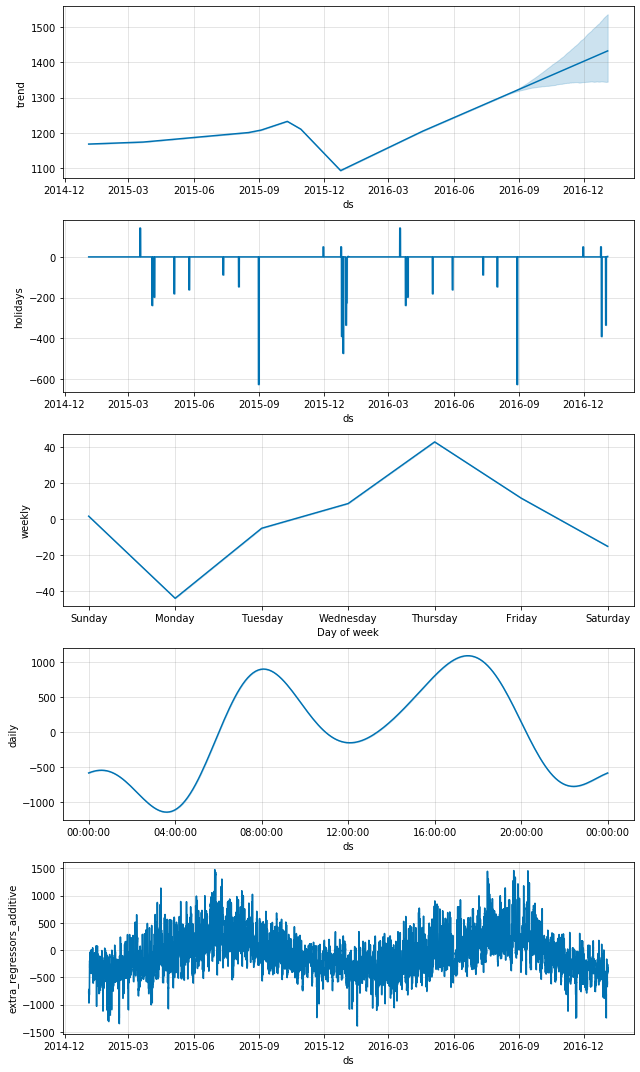

In [16]:
modelbk[`:plot_components][.ml.tab2df forecastbk];
p)plt.show()